## Example3.1: 20 Cell Microcircuit Simulation

Mechanisms found:  True
Initiating HL23PN1 population...
Initiating HL23MN1 population...
Initiating HL23BN1 population...
Initiating HL23VN1 population...
Connected population HL23PN1 to HL23PN1 by 77 connections and 231 synapses
Connected population HL23PN1 to HL23MN1 by 0 connections and 0 synapses
Connected population HL23PN1 to HL23BN1 by 1 connections and 8 synapses
Connected population HL23PN1 to HL23VN1 by 2 connections and 8 synapses
Connected population HL23MN1 to HL23PN1 by 3 connections and 36 synapses
Connected population HL23MN1 to HL23MN1 by 0 connections and 0 synapses
Connected population HL23MN1 to HL23BN1 by 0 connections and 0 synapses
Connected population HL23MN1 to HL23VN1 by 2 connections and 10 synapses
Connected population HL23BN1 to HL23PN1 by 2 connections and 34 synapses
Connected population HL23BN1 to HL23MN1 by 0 connections and 0 synapses
Connected population HL23BN1 to HL23BN1 by 0 connections and 0 synapses
Connected population HL23BN1 to HL23VN1 by 0 c

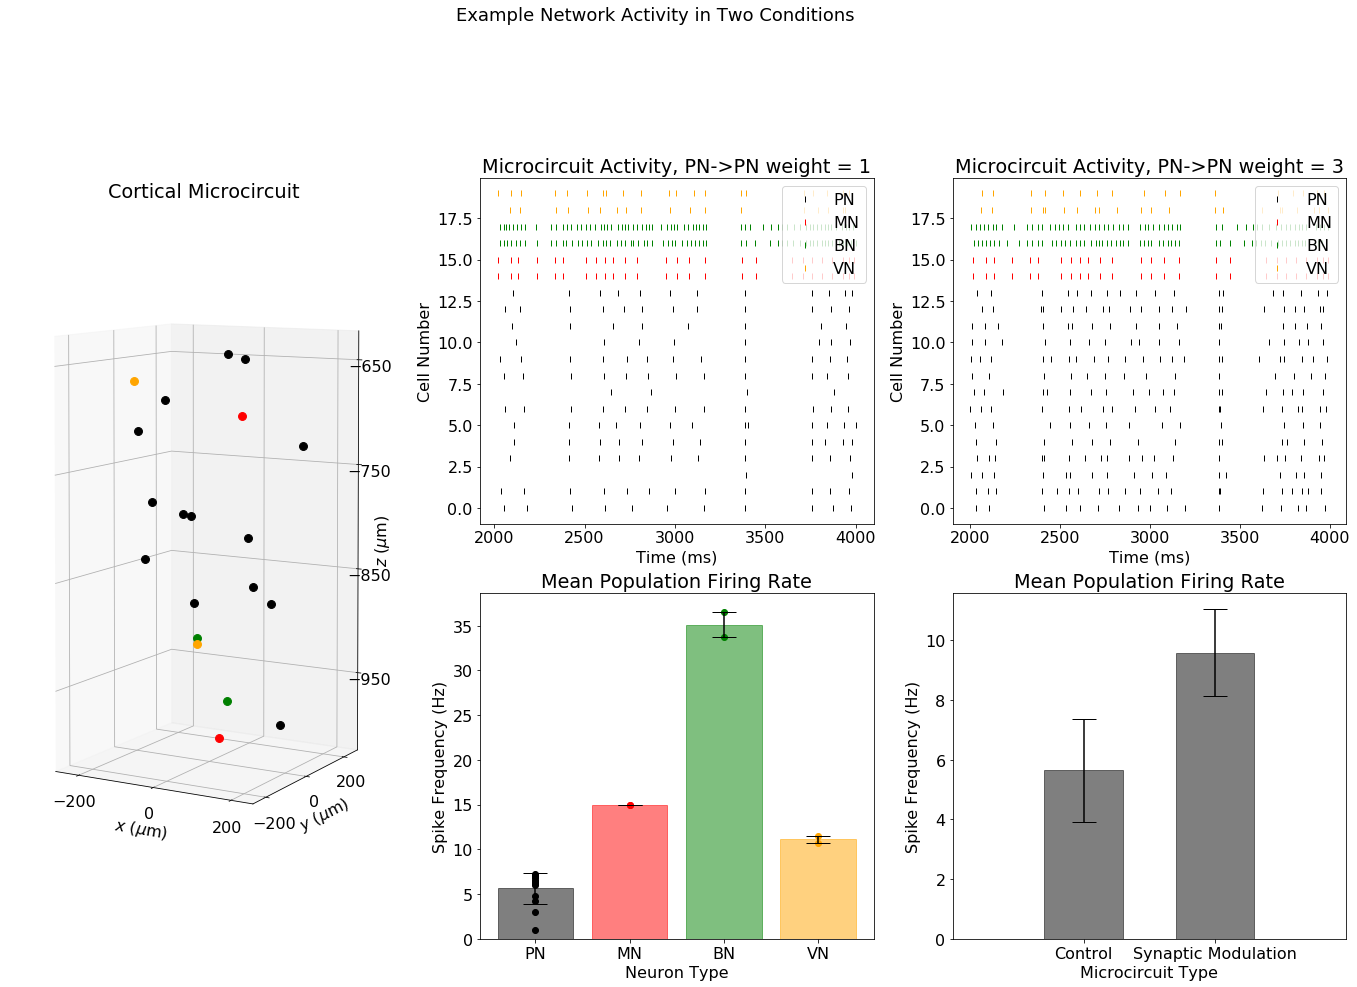

In [1]:
################################################################################################################
# 2020 Hay lab, Krembil Centre for Neuroinformatics, Summer School. Code available for educational purposes only
################################################################################################################
####################################################################
# Import Modules and load relevant files
####################################################################
import os
import time
tic = time.perf_counter()
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *

print('Mechanisms found: ', os.path.isfile('mod/x86_64/special'))
neuron.h('forall delete_section()')
neuron.load_mechanisms('mod/')
h.load_file('net_functions.hoc')
h.load_file('models/biophys_HL23PN1.hoc')
h.load_file('models/biophys_HL23MN1.hoc')
h.load_file('models/biophys_HL23BN1.hoc')
h.load_file('models/biophys_HL23VN1.hoc')

####################################################################
# Simulation Controls
####################################################################

N_HL23PN = 14
N_HL23MN = 2
N_HL23BN = 2
N_HL23VN = 2

#PN2PN to all 
connection_strength = 3

####################################################################
# Parameters
####################################################################
dt = 2**-4
tstart = 0.
tmid = 0. 
tstop = 4000.
celsius = 34.
v_init = -80.

L23_pop_args = {'radius':250,
                'loc':-800,
                'scale':500,
                'cap': float(200)}

rotations = {'HL23PN1':{'x':1.57,'y':2.62},
             'HL23MN1':{'x':1.77,'y':2.77},
             'HL23BN1':{'x':1.26,'y':2.57},
             'HL23VN1':{'x':-1.57,'y':3.57}}

networkParams = {
    'dt' : dt,
    'tstart': tstart,
    'tstop' : tstop,
    'v_init' : v_init,
    'celsius' : celsius,
    'verbose' : False,
    'OUTPUTPATH': 'Circuit_output/E3_1/'}

#method Network.simulate() parameters
simargs = {'rec_imem': False,
           'rec_vmem': False,
           'rec_ipas': False,
           'rec_icap': False,
           'rec_isyn': False,
           'rec_vmemsyn': False,
           'rec_istim': False,
           'rec_current_dipole_moment': False,
           'rec_pop_contributions': False,
           'rec_variables': [],
           'to_memory': False,
           'to_file': False,
           'file_name':'OUTPUT.h5',
           'dotprodcoeffs': None}

####################################################################
# Create Population Function
####################################################################
def generateSubPop(popsize,mname,popargs,Gou,Gtonic):
    print('Initiating ' + mname + ' population...')
    morphpath = 'morphologies/' + mname + '.swc'
    templatepath = 'models/NeuronTemplate.hoc'
    templatename = 'NeuronTemplate'

    cellParams = {
        'morphology': morphpath,
        'templatefile': templatepath,
        'templatename': templatename,
        'templateargs': morphpath,
        'v_init': v_init,
        'passive': False,
        'dt': dt,
        'tstart': 0.,
        'tstop': tstop,#defaults to 100
        'nsegs_method': None,
        'pt3d': False,
        'delete_sections': False,
        'verbose': False}

    rotation = rotations.get(mname)

    popParams = {
        'CWD': None,
        'CELLPATH': None,
        'Cell' : LFPy.NetworkCell,
        'POP_SIZE': popsize,
        'name': mname,
        'cell_args' : cellParams,
        'pop_args' : popargs,
        'rotation_args' : rotation}

    network.create_population(**popParams)
    # Add biophys, OU processes, & tonic inhibition to cells
    for cellind in range(0,len(network.populations[mname].cells)): #0 is redundant?
        biophys = 'h.biophys_' + mname + '(network.populations[\'' + mname + '\'].cells[' + str(cellind) + '].template)'
        exec(biophys)
        rseed = 1234
        h.createArtificialSyn(rseed,network.populations[mname].cells[cellind].template,Gou)
        h.addTonicInhibition(network.populations[mname].cells[cellind].template,Gtonic,Gtonic)
####################################################################
# Run Simulation
####################################################################
network = Network(**networkParams)

generateSubPop(N_HL23PN,'HL23PN1',L23_pop_args,0.00004,0.000827)
generateSubPop(N_HL23MN,'HL23MN1',L23_pop_args,0.00005,0.000827)
generateSubPop(N_HL23BN,'HL23BN1',L23_pop_args,0.00045,0.000827)
generateSubPop(N_HL23VN,'HL23VN1',L23_pop_args,0.00009,0.000827)

E_syn = neuron.h.ProbAMPANMDA
I_syn = neuron.h.ProbUDFsyn

weightFunction = np.random.normal
WP = {'loc':1, 'scale':0.0000001}

PN_WP = {'loc':connection_strength, 'scale':0.0000001}

delayFunction = np.random.normal
delayParams = {'loc':.5, 'scale':0.0000001}
mindelay=0.5

multapseFunction = np.random.normal

connectionProbability = [[connection_prob['HL23PN1HL23PN1'],connection_prob['HL23PN1HL23MN1'],connection_prob['HL23PN1HL23BN1'],connection_prob['HL23PN1HL23VN1']],
                         [connection_prob['HL23MN1HL23PN1'],connection_prob['HL23MN1HL23MN1'],connection_prob['HL23MN1HL23BN1'],connection_prob['HL23MN1HL23VN1']],
                         [connection_prob['HL23BN1HL23PN1'],connection_prob['HL23BN1HL23MN1'],connection_prob['HL23BN1HL23BN1'],connection_prob['HL23BN1HL23VN1']],
                         [connection_prob['HL23VN1HL23PN1'],connection_prob['HL23VN1HL23MN1'],connection_prob['HL23VN1HL23BN1'],connection_prob['HL23VN1HL23VN1']]]

synapseParameters = [[syn_params['HL23PN1HL23PN1'],syn_params['HL23PN1HL23MN1'],syn_params['HL23PN1HL23BN1'],syn_params['HL23PN1HL23VN1']],
                     [syn_params['HL23MN1HL23PN1'],syn_params['HL23MN1HL23MN1'],syn_params['HL23MN1HL23BN1'],syn_params['HL23MN1HL23VN1']],
                     [syn_params['HL23BN1HL23PN1'],syn_params['HL23BN1HL23MN1'],syn_params['HL23BN1HL23BN1'],syn_params['HL23BN1HL23VN1']],
                     [syn_params['HL23VN1HL23PN1'],syn_params['HL23VN1HL23MN1'],syn_params['HL23VN1HL23BN1'],syn_params['HL23VN1HL23VN1']]]

weightArguments = [[PN_WP, WP, WP, WP],
                   [WP, WP, WP, WP],
                   [WP, WP, WP, WP], 
                   [WP, WP, WP, WP]]

minweight = [[connection_strength, 1, 1, 1],
             [1, 1, 1, 1], 
             [1, 1, 1, 1], 
             [1, 1, 1, 1]]

delayArguments = np.full([4, 4], delayParams)

multapseArguments = [[mult_syns['HL23PN1HL23PN1'],mult_syns['HL23PN1HL23MN1'],mult_syns['HL23PN1HL23BN1'],mult_syns['HL23PN1HL23VN1']],
                     [mult_syns['HL23MN1HL23PN1'],mult_syns['HL23MN1HL23MN1'],mult_syns['HL23MN1HL23BN1'],mult_syns['HL23MN1HL23VN1']],
                     [mult_syns['HL23BN1HL23PN1'],mult_syns['HL23BN1HL23MN1'],mult_syns['HL23BN1HL23BN1'],mult_syns['HL23BN1HL23VN1']],
                     [mult_syns['HL23VN1HL23PN1'],mult_syns['HL23VN1HL23MN1'],mult_syns['HL23VN1HL23BN1'],mult_syns['HL23VN1HL23VN1']]]

synapsePositionArguments = [[pos_args['HL23PN1HL23PN1'],pos_args['HL23PN1HL23MN1'],pos_args['HL23PN1HL23BN1'],pos_args['HL23PN1HL23VN1']],
                            [pos_args['HL23MN1HL23PN1'],pos_args['HL23MN1HL23MN1'],pos_args['HL23MN1HL23BN1'],pos_args['HL23MN1HL23VN1']],
                            [pos_args['HL23BN1HL23PN1'],pos_args['HL23BN1HL23MN1'],pos_args['HL23BN1HL23BN1'],pos_args['HL23BN1HL23VN1']],
                            [pos_args['HL23VN1HL23PN1'],pos_args['HL23VN1HL23MN1'],pos_args['HL23VN1HL23BN1'],pos_args['HL23VN1HL23VN1']]]

for i, pre in enumerate(network.population_names):
    for j, post in enumerate(network.population_names):

        connectivity = network.get_connectivity_rand(
            pre=pre,
            post=post,
            connprob=connectionProbability[i][j])

        (conncount, syncount) = network.connect(
            pre=pre, post=post,
            connectivity=connectivity,
            syntype=E_syn if pre=='HL23PN1' else I_syn,
            synparams=synapseParameters[i][j],
            weightfun=weightFunction,
            weightargs=weightArguments[i][j],
            minweight=minweight[i][j],
            delayfun=delayFunction,
            delayargs=delayArguments[i][j],
            mindelay=mindelay,
            multapsefun=multapseFunction,
            multapseargs=multapseArguments[i][j],
            syn_pos_args=synapsePositionArguments[i][j])

SPIKES = network.simulate(**simargs)

####################################################################
# Plotting
####################################################################

print('Simulation complete ... plotting output ...')

font={'size':16}
matplotlib.rc('font', **font)

###################################
# Population Morphology
###################################

fig = plt.figure(figsize=([24, 14]))
ax = fig.add_subplot(131, projection='3d')
clrs = ['k', 'red', 'green', 'orange']
ax.view_init(elev=5)
for i, (name, pop) in enumerate(network.populations.items()):
    for cell in pop.cells:
        ax.scatter(cell.somapos[0], cell.somapos[1], cell.somapos[2], c=clrs[i], marker='.', s=250)
    ax.set_xlabel('$x$ ($\mu$m)')
    ax.set_ylabel('$y$ ($\mu$m)')
    ax.set_zlabel('$z$ ($\mu$m)')
    ax.set_xticks([-200, 0, 200])
    ax.set_yticks([-200, 0, 200])
    ax.set_zticks([-650, -750, -850, -950])
    ax.set_title('Cortical Microcircuit', y=1.05)
    
###################################
# Connection Strength = 1
###################################
###################################
# Raster Plot
###################################
SPIKES_1 = np.load('Circuit_output/E3_1/3_1_SPIKES.npy', allow_pickle=True)
popnames = ['PN', 'MN', 'BN', 'VN']
clrs = ['k', 'red', 'green', 'orange']
ax = fig.add_subplot(232)
for color, name, spts, gids in zip(clrs, popnames, SPIKES_1.item(0)['times'], SPIKES_1.item(0)['gids']):
    t = []
    g = []
    for spt, gid in zip(spts, gids):
        t = np.r_[t, spt]
        g = np.r_[g, np.zeros(spt.size)+gid]
    ax.plot(t[t >= 2000], g[t >= 2000], '|', color=color, label=name)
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_xticks(np.arange(2000, 4500, 500))
ax.set_ylabel('Cell Number')
ax.set_title('Microcircuit Activity, PN->PN weight = 1')

###################################
# Spike Rates
###################################
                 
PN_Hz = []
for i in range(len(SPIKES_1.item(0)['times'][0])):
    Hz = (SPIKES_1.item(0)['times'][0][i].size)/(network.tstop/1000)
    PN_Hz.append(Hz)

MN_Hz = []
for i in range(len(SPIKES_1.item(0)['times'][1])):
    Hz = (SPIKES_1.item(0)['times'][1][i].size)/(network.tstop/1000)
    MN_Hz.append(Hz)

BN_Hz = []
for i in range(len(SPIKES_1.item(0)['times'][2])):
    Hz = (SPIKES_1.item(0)['times'][2][i].size)/(network.tstop/1000)
    BN_Hz.append(Hz)

VN_Hz = []
for i in range(len(SPIKES_1.item(0)['times'][3])):
    Hz = (SPIKES_1.item(0)['times'][3][i].size)/(network.tstop/1000)
    VN_Hz.append(Hz)

w = 0.8
x = [0, 1, 2, 3]

Hzs = [PN_Hz, MN_Hz, BN_Hz, VN_Hz]
names = ['PN', 'MN', 'BN', 'VN']
colors = ['k', 'red', 'green', 'orange']
secondx=[]
for i, j in enumerate(Hzs):
    length = np.ones(len(j))*i
    secondx.append(length)

ax = fig.add_subplot(235)

ax.bar(x,height=[np.mean(cell) for cell in Hzs],
       yerr=[np.std(cell) for cell in Hzs],
       capsize=12,
       width=w,
       tick_label=names,
       color=[clr for clr in colors],
       edgecolor=[clr for clr in colors],
       ecolor='black',
       alpha=0.5)

for i in range(4):
    ax.scatter(secondx[i]+.5* w - w / 2, Hzs[i], color=colors[i])
    ax.set_ylabel('Spike Frequency (Hz)')
    ax.set_xlabel('Neuron Type')
    ax.set_title('Mean Population Firing Rate')
    ax.grid(False)

###################################
# Connection Strength < 1
###################################
###################################
# Raster Plot
###################################
popnames = ['PN', 'MN', 'BN', 'VN']
clrs = ['k', 'red', 'green', 'orange']
ax = fig.add_subplot(233)
for color, name, spts, gids in zip(clrs, popnames, SPIKES['times'], SPIKES['gids']):
    t = []
    g = []
    for spt, gid in zip(spts, gids):
        t = np.r_[t, spt]
        g = np.r_[g, np.zeros(spt.size)+gid]
    ax.plot(t[t >= 2000], g[t >= 2000], '|', color=color, label=name)
ax.legend(loc=1)
ax.set_xticks(np.arange(2000, 4500, 500))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Cell Number')
title = 'Microcircuit Activity, PN->PN weight = '+str(connection_strength)
ax.set_title(title)

###################################
# Spike Rates
###################################
                 
PN_1_Hz = []
for i in range(len(SPIKES_1.item(0)['times'][0])):
    Hz = (SPIKES_1.item(0)['times'][0][i].size)/(network.tstop/1000)
    PN_1_Hz.append(Hz)

PN_2_Hz = []
for i in range(len(SPIKES['times'][0])):
    Hz = (SPIKES['times'][0][i].size)/(network.tstop/1000)
    PN_2_Hz.append(Hz)


w = 0.8
x = [0, 1, 2, 3]

Hzs = [PN_Hz, PN_2_Hz]
names = ['Control', 'Synaptic Modulation']
colors = ['black', 'black']
secondx=[]
for i, j in enumerate(Hzs):
    length = np.ones(len(j))*i
    secondx.append(length)

ax2 = fig.add_subplot(236)
w = 1.2
ax2.bar(x = [2, 4],
       height=[np.mean(cell) for cell in Hzs],
       yerr=[np.std(cell) for cell in Hzs],
       capsize=12,
       width=w,
       tick_label=names,
       color=[clr for clr in colors],
       edgecolor=[clr for clr in colors],
       ecolor='black',
       alpha=0.5,
       align='center')
ax2.set_xlim([0, 6])
ax2.set_ylabel('Spike Frequency (Hz)')
ax2.set_title('Mean Population Firing Rate')
ax2.set_xlabel('Microcircuit Type')
ax2.grid(False)

plt.suptitle('Example Network Activity in Two Conditions', y=1.0, fontsize=18)
tock = time.perf_counter()
simtime = tock - tic
print('simulation took ', simtime)

network.pc.gid_clear()
electrode = None
syn = None
synapseModel = None
for population in network.populations.values():
    for cell in population.cells:
        cell = None
        population.cells = None
    population = None
    pop = None
    network = None
    neuron.h('forall delete_section()')